In [1]:
import tensorflow as tf
print('tf: {0}'.format(tf.__version__))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

tf: 2.0.0
Num GPUs Available:  0


In [6]:
from tensorflow.keras import layers

In [3]:
# 准备数据
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

BUFFER_SIZE = 60000
BATCH_SIZE = 256

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [52]:
class Discriminator(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.flatten = tf.keras.layers.Flatten()      # Flatten层将除第一维（batch_size）以外的维度展平
        self.dense1 = tf.keras.layers.Dense(units=128, activation=tf.keras.activations.relu,bias_initializer=tf.zeros_initializer())
        self.dense2 = tf.keras.layers.Dense(units=1, activation=tf.keras.activations.sigmoid)
        
    def call(self,input):                            # [batch_size, 28, 28, 1]
        x = self.flatten(input)                      # [batch_size, 784]
        x = self.dense1(x)                           # [batch_size, 128]
        x = self.dense2(x)                           # [batch_size, 1]
        return x
    
class Generator(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.dense1  = tf.keras.layers.Dense(units=128, activation=tf.keras.activations.relu)
        self.dense2  = tf.keras.layers.Dense(units=784, activation=tf.keras.activations.sigmoid)
        self.reshape =  tf.keras.layers.Reshape(target_shape=(28, 28, 1))
        
    def call(self,input):         # [batch_size, 100]
        x = self.dense1(input)    # [batch_size, 128]
        x = self.dense2(x)        # [batch_size, 784]
        x = self.reshape(x)       # [batch_size, 28, 28, 1]
        return x

In [7]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

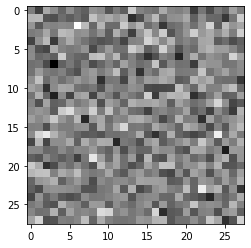

In [53]:
#import matplotlib.pyplot as plt

generator = Generator()#make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [9]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [54]:
discriminator = Discriminator()#make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.6308204]], shape=(1, 1), dtype=float32)


In [11]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [19]:
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [15]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

In [103]:
def train(dataset, epochs):
    #for epoch in range(epochs):
        #start = time.time()
    for epoch in range(epochs):
        for i,image_batch in enumerate(dataset):
            g,d = train_step(image_batch)
            print("batch %d, gen_loss %f,disc_loss %f" % (i, g.numpy(),d.numpy()))

'''
    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch + 1, seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, seed)
'''

def other():
    print(0)

"\n    # Produce images for the GIF as we go\n    display.clear_output(wait=True)\n    generate_and_save_images(generator, epoch + 1, seed)\n\n    # Save the model every 15 epochs\n    if (epoch + 1) % 15 == 0:\n        checkpoint.save(file_prefix = checkpoint_prefix)\n\n    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))\n\n  # Generate after the final epoch\n  display.clear_output(wait=True)\n  generate_and_save_images(generator, epochs, seed)\n"

In [104]:
EPOCHS = 10
train(train_dataset, EPOCHS)

batch 0, gen_loss 0.902442,disc_loss 1.208091
batch 1, gen_loss 0.925489,disc_loss 1.138894
batch 2, gen_loss 0.997722,disc_loss 1.095758
batch 3, gen_loss 0.962782,disc_loss 1.105824
batch 4, gen_loss 0.882296,disc_loss 1.176620
batch 5, gen_loss 0.875340,disc_loss 1.161040
batch 6, gen_loss 0.908787,disc_loss 1.064392
batch 7, gen_loss 0.919660,disc_loss 1.141892
batch 8, gen_loss 0.973278,disc_loss 1.111685
batch 9, gen_loss 1.050881,disc_loss 1.153429
batch 10, gen_loss 0.968966,disc_loss 1.122620
batch 11, gen_loss 0.977007,disc_loss 1.125437
batch 12, gen_loss 0.915537,disc_loss 1.116558
batch 13, gen_loss 0.911294,disc_loss 1.140381
batch 14, gen_loss 0.924497,disc_loss 1.140242
batch 15, gen_loss 0.924846,disc_loss 1.126991
batch 16, gen_loss 0.968786,disc_loss 1.095679
batch 17, gen_loss 1.020759,disc_loss 1.115838
batch 18, gen_loss 1.042583,disc_loss 1.064072
batch 19, gen_loss 1.018838,disc_loss 1.049722
batch 20, gen_loss 1.024575,disc_loss 1.053359
batch 21, gen_loss 1.06

batch 173, gen_loss 0.990289,disc_loss 1.169292
batch 174, gen_loss 0.950982,disc_loss 1.175971
batch 175, gen_loss 0.937080,disc_loss 1.220221
batch 176, gen_loss 0.883481,disc_loss 1.195262
batch 177, gen_loss 0.850060,disc_loss 1.177074
batch 178, gen_loss 0.826223,disc_loss 1.278283
batch 179, gen_loss 0.889309,disc_loss 1.275254
batch 180, gen_loss 0.913712,disc_loss 1.251011
batch 181, gen_loss 0.870262,disc_loss 1.223617
batch 182, gen_loss 0.880946,disc_loss 1.306237
batch 183, gen_loss 0.874752,disc_loss 1.222107
batch 184, gen_loss 0.837633,disc_loss 1.287967
batch 185, gen_loss 0.802721,disc_loss 1.253617
batch 186, gen_loss 0.896647,disc_loss 1.235566
batch 187, gen_loss 0.883229,disc_loss 1.293364
batch 188, gen_loss 0.858424,disc_loss 1.252527
batch 189, gen_loss 0.888885,disc_loss 1.203009
batch 190, gen_loss 0.856396,disc_loss 1.202087
batch 191, gen_loss 0.862180,disc_loss 1.285585
batch 192, gen_loss 0.881782,disc_loss 1.231749
batch 193, gen_loss 0.924560,disc_loss 1

batch 111, gen_loss 1.138852,disc_loss 1.022417
batch 112, gen_loss 1.130996,disc_loss 1.081030
batch 113, gen_loss 1.075939,disc_loss 1.003162
batch 114, gen_loss 1.126298,disc_loss 1.020494
batch 115, gen_loss 1.160593,disc_loss 1.077261
batch 116, gen_loss 1.180021,disc_loss 1.057745
batch 117, gen_loss 1.112771,disc_loss 1.079287
batch 118, gen_loss 1.095969,disc_loss 1.094552
batch 119, gen_loss 1.087441,disc_loss 1.154312
batch 120, gen_loss 1.067839,disc_loss 1.142258
batch 121, gen_loss 1.025979,disc_loss 1.124278
batch 122, gen_loss 1.002599,disc_loss 1.183768
batch 123, gen_loss 1.080135,disc_loss 1.179554
batch 124, gen_loss 1.064325,disc_loss 1.215682
batch 125, gen_loss 1.057119,disc_loss 1.129614
batch 126, gen_loss 1.011078,disc_loss 1.245931
batch 127, gen_loss 0.969010,disc_loss 1.251679
batch 128, gen_loss 0.982819,disc_loss 1.196506
batch 129, gen_loss 1.021331,disc_loss 1.258177
batch 130, gen_loss 1.007038,disc_loss 1.285619
batch 131, gen_loss 0.938773,disc_loss 1

batch 48, gen_loss 0.860003,disc_loss 1.183185
batch 49, gen_loss 0.874634,disc_loss 1.181753
batch 50, gen_loss 0.867800,disc_loss 1.161881
batch 51, gen_loss 0.896784,disc_loss 1.140034
batch 52, gen_loss 0.887451,disc_loss 1.214212
batch 53, gen_loss 0.880542,disc_loss 1.210796
batch 54, gen_loss 0.889363,disc_loss 1.206561
batch 55, gen_loss 0.859282,disc_loss 1.224716
batch 56, gen_loss 0.823953,disc_loss 1.172330
batch 57, gen_loss 0.823742,disc_loss 1.228231
batch 58, gen_loss 0.831765,disc_loss 1.229645
batch 59, gen_loss 0.865192,disc_loss 1.226700
batch 60, gen_loss 0.891472,disc_loss 1.202539
batch 61, gen_loss 0.881751,disc_loss 1.238068
batch 62, gen_loss 0.875392,disc_loss 1.282140
batch 63, gen_loss 0.831387,disc_loss 1.229341
batch 64, gen_loss 0.815523,disc_loss 1.268093
batch 65, gen_loss 0.804122,disc_loss 1.234461
batch 66, gen_loss 0.809946,disc_loss 1.275426
batch 67, gen_loss 0.846358,disc_loss 1.237062
batch 68, gen_loss 0.832396,disc_loss 1.285389
batch 69, gen

batch 220, gen_loss 0.877960,disc_loss 1.273269
batch 221, gen_loss 0.873683,disc_loss 1.262623
batch 222, gen_loss 0.886307,disc_loss 1.267099
batch 223, gen_loss 0.886914,disc_loss 1.265039
batch 224, gen_loss 0.888973,disc_loss 1.263961
batch 225, gen_loss 0.854084,disc_loss 1.284708
batch 226, gen_loss 0.841086,disc_loss 1.281223
batch 227, gen_loss 0.821679,disc_loss 1.256835
batch 228, gen_loss 0.848627,disc_loss 1.284970
batch 229, gen_loss 0.815260,disc_loss 1.335358
batch 230, gen_loss 0.833310,disc_loss 1.299550
batch 231, gen_loss 0.830916,disc_loss 1.289692
batch 232, gen_loss 0.800998,disc_loss 1.314103
batch 233, gen_loss 0.800518,disc_loss 1.263860
batch 234, gen_loss 0.796926,disc_loss 1.270785
batch 0, gen_loss 0.842758,disc_loss 1.287923
batch 1, gen_loss 0.814099,disc_loss 1.301116
batch 2, gen_loss 0.789065,disc_loss 1.298562
batch 3, gen_loss 0.771508,disc_loss 1.277773
batch 4, gen_loss 0.780155,disc_loss 1.257676
batch 5, gen_loss 0.804972,disc_loss 1.236809
batc

batch 158, gen_loss 0.913808,disc_loss 1.163197
batch 159, gen_loss 0.907725,disc_loss 1.176331
batch 160, gen_loss 0.923348,disc_loss 1.174541
batch 161, gen_loss 0.918418,disc_loss 1.175645
batch 162, gen_loss 0.911241,disc_loss 1.153488
batch 163, gen_loss 0.856122,disc_loss 1.222234
batch 164, gen_loss 0.861102,disc_loss 1.189053
batch 165, gen_loss 0.881304,disc_loss 1.196266
batch 166, gen_loss 0.861989,disc_loss 1.201803
batch 167, gen_loss 0.890562,disc_loss 1.186942
batch 168, gen_loss 0.877133,disc_loss 1.186264
batch 169, gen_loss 0.881027,disc_loss 1.194292
batch 170, gen_loss 0.878915,disc_loss 1.209756
batch 171, gen_loss 0.862336,disc_loss 1.214691
batch 172, gen_loss 0.872365,disc_loss 1.214049
batch 173, gen_loss 0.879212,disc_loss 1.227222
batch 174, gen_loss 0.871576,disc_loss 1.223983
batch 175, gen_loss 0.829491,disc_loss 1.263459
batch 176, gen_loss 0.809666,disc_loss 1.265036
batch 177, gen_loss 0.825117,disc_loss 1.240953
batch 178, gen_loss 0.835720,disc_loss 1

batch 96, gen_loss 1.024952,disc_loss 1.365139
batch 97, gen_loss 0.999838,disc_loss 1.395730
batch 98, gen_loss 0.848704,disc_loss 1.467855
batch 99, gen_loss 0.815579,disc_loss 1.472310
batch 100, gen_loss 0.823936,disc_loss 1.450240
batch 101, gen_loss 0.816649,disc_loss 1.513019
batch 102, gen_loss 0.821685,disc_loss 1.606321
batch 103, gen_loss 0.821131,disc_loss 1.493696
batch 104, gen_loss 0.853068,disc_loss 1.549946
batch 105, gen_loss 0.780238,disc_loss 1.611247
batch 106, gen_loss 0.745467,disc_loss 1.610263
batch 107, gen_loss 0.759376,disc_loss 1.600048
batch 108, gen_loss 0.662101,disc_loss 1.663433
batch 109, gen_loss 0.661321,disc_loss 1.606719
batch 110, gen_loss 0.711721,disc_loss 1.717780
batch 111, gen_loss 0.725024,disc_loss 1.689469
batch 112, gen_loss 0.678485,disc_loss 1.683775
batch 113, gen_loss 0.688631,disc_loss 1.646808
batch 114, gen_loss 0.679314,disc_loss 1.653378
batch 115, gen_loss 0.678056,disc_loss 1.655366
batch 116, gen_loss 0.645987,disc_loss 1.765

batch 33, gen_loss 0.856252,disc_loss 1.359955
batch 34, gen_loss 0.773206,disc_loss 1.257116
batch 35, gen_loss 0.781468,disc_loss 1.372501
batch 36, gen_loss 0.802556,disc_loss 1.284829
batch 37, gen_loss 0.875392,disc_loss 1.310252
batch 38, gen_loss 0.921907,disc_loss 1.319588
batch 39, gen_loss 0.963870,disc_loss 1.272413
batch 40, gen_loss 0.922625,disc_loss 1.276669
batch 41, gen_loss 0.851240,disc_loss 1.234659
batch 42, gen_loss 0.867727,disc_loss 1.191303
batch 43, gen_loss 0.894578,disc_loss 1.212909
batch 44, gen_loss 0.927529,disc_loss 1.228317
batch 45, gen_loss 0.942412,disc_loss 1.262264
batch 46, gen_loss 0.982052,disc_loss 1.245545
batch 47, gen_loss 0.952677,disc_loss 1.229975
batch 48, gen_loss 0.945571,disc_loss 1.218031
batch 49, gen_loss 0.888310,disc_loss 1.326503
batch 50, gen_loss 0.904504,disc_loss 1.257640
batch 51, gen_loss 0.856991,disc_loss 1.285142
batch 52, gen_loss 0.876838,disc_loss 1.262820
batch 53, gen_loss 0.907872,disc_loss 1.315666
batch 54, gen

batch 206, gen_loss 0.977970,disc_loss 1.292973
batch 207, gen_loss 0.995838,disc_loss 1.212516
batch 208, gen_loss 0.946892,disc_loss 1.253564
batch 209, gen_loss 0.990430,disc_loss 1.234404
batch 210, gen_loss 0.930559,disc_loss 1.174925
batch 211, gen_loss 1.005737,disc_loss 1.162771
batch 212, gen_loss 1.039607,disc_loss 1.212898
batch 213, gen_loss 1.034029,disc_loss 1.191294
batch 214, gen_loss 1.049926,disc_loss 1.152947
batch 215, gen_loss 1.057914,disc_loss 1.178036
batch 216, gen_loss 1.043846,disc_loss 1.164995
batch 217, gen_loss 1.071169,disc_loss 1.081990
batch 218, gen_loss 1.024156,disc_loss 1.072636
batch 219, gen_loss 1.059772,disc_loss 1.084076
batch 220, gen_loss 0.989559,disc_loss 1.036350
batch 221, gen_loss 0.987633,disc_loss 1.105878
batch 222, gen_loss 1.028837,disc_loss 1.011574
batch 223, gen_loss 1.039551,disc_loss 1.079221
batch 224, gen_loss 1.055391,disc_loss 1.088602
batch 225, gen_loss 1.102632,disc_loss 1.014652
batch 226, gen_loss 1.165065,disc_loss 1

batch 144, gen_loss 1.035405,disc_loss 1.042865
batch 145, gen_loss 1.114310,disc_loss 1.046490
batch 146, gen_loss 1.105657,disc_loss 1.090906
batch 147, gen_loss 1.122795,disc_loss 1.073029
batch 148, gen_loss 1.037965,disc_loss 1.054491
batch 149, gen_loss 1.122458,disc_loss 1.075497
batch 150, gen_loss 1.045445,disc_loss 1.091452
batch 151, gen_loss 1.083142,disc_loss 1.056868
batch 152, gen_loss 1.005975,disc_loss 1.169007
batch 153, gen_loss 1.045535,disc_loss 1.103892
batch 154, gen_loss 1.013845,disc_loss 1.140804
batch 155, gen_loss 0.994638,disc_loss 1.195987
batch 156, gen_loss 1.058196,disc_loss 1.170587
batch 157, gen_loss 1.002997,disc_loss 1.214299
batch 158, gen_loss 0.911556,disc_loss 1.298405
batch 159, gen_loss 0.840694,disc_loss 1.307180
batch 160, gen_loss 0.896623,disc_loss 1.325787
batch 161, gen_loss 0.920536,disc_loss 1.351020
batch 162, gen_loss 0.935970,disc_loss 1.332460
batch 163, gen_loss 0.918811,disc_loss 1.477403
batch 164, gen_loss 0.868942,disc_loss 1

batch 82, gen_loss 0.982475,disc_loss 1.110144
batch 83, gen_loss 0.998014,disc_loss 1.072436
batch 84, gen_loss 0.997838,disc_loss 1.105365
batch 85, gen_loss 0.994901,disc_loss 1.031587
batch 86, gen_loss 0.961032,disc_loss 1.090998
batch 87, gen_loss 0.997613,disc_loss 1.085986
batch 88, gen_loss 0.988350,disc_loss 1.064018
batch 89, gen_loss 1.001651,disc_loss 1.076654
batch 90, gen_loss 1.027261,disc_loss 1.020578
batch 91, gen_loss 1.018559,disc_loss 1.019033
batch 92, gen_loss 0.990454,disc_loss 1.042636
batch 93, gen_loss 1.040120,disc_loss 1.002717
batch 94, gen_loss 1.061231,disc_loss 1.012924
batch 95, gen_loss 1.087672,disc_loss 1.023182
batch 96, gen_loss 1.082993,disc_loss 1.045740
batch 97, gen_loss 1.064118,disc_loss 0.980693
batch 98, gen_loss 0.992215,disc_loss 0.975581
batch 99, gen_loss 1.090753,disc_loss 0.975920
batch 100, gen_loss 1.122752,disc_loss 0.925693
batch 101, gen_loss 1.103030,disc_loss 0.942630
batch 102, gen_loss 1.168638,disc_loss 0.933727
batch 103,

batch 19, gen_loss 1.273812,disc_loss 0.876566
batch 20, gen_loss 1.286346,disc_loss 0.839807
batch 21, gen_loss 1.330826,disc_loss 0.820199
batch 22, gen_loss 1.283190,disc_loss 0.878987
batch 23, gen_loss 1.209597,disc_loss 0.904794
batch 24, gen_loss 1.213423,disc_loss 0.848412
batch 25, gen_loss 1.212972,disc_loss 0.848438
batch 26, gen_loss 1.210261,disc_loss 0.896409
batch 27, gen_loss 1.170178,disc_loss 0.924719
batch 28, gen_loss 1.153788,disc_loss 0.883196
batch 29, gen_loss 1.156747,disc_loss 0.936986
batch 30, gen_loss 1.201455,disc_loss 0.987407
batch 31, gen_loss 1.177197,disc_loss 0.920257
batch 32, gen_loss 1.155915,disc_loss 0.974470
batch 33, gen_loss 1.135793,disc_loss 1.017876
batch 34, gen_loss 1.082351,disc_loss 1.019510
batch 35, gen_loss 1.031072,disc_loss 1.081482
batch 36, gen_loss 1.007469,disc_loss 1.028579
batch 37, gen_loss 0.964138,disc_loss 1.114344
batch 38, gen_loss 1.060633,disc_loss 1.053610
batch 39, gen_loss 1.023469,disc_loss 1.187617
batch 40, gen

batch 192, gen_loss 0.956629,disc_loss 1.237626
batch 193, gen_loss 0.853126,disc_loss 1.296063
batch 194, gen_loss 0.899543,disc_loss 1.247212
batch 195, gen_loss 0.910011,disc_loss 1.264039
batch 196, gen_loss 0.906716,disc_loss 1.284000
batch 197, gen_loss 0.882779,disc_loss 1.299648
batch 198, gen_loss 0.867287,disc_loss 1.288237
batch 199, gen_loss 0.852247,disc_loss 1.325482
batch 200, gen_loss 0.818020,disc_loss 1.345433
batch 201, gen_loss 0.869713,disc_loss 1.389812
batch 202, gen_loss 0.879076,disc_loss 1.393283
batch 203, gen_loss 0.860095,disc_loss 1.384343
batch 204, gen_loss 0.830042,disc_loss 1.413499
batch 205, gen_loss 0.858864,disc_loss 1.350356
batch 206, gen_loss 0.815758,disc_loss 1.391145
batch 207, gen_loss 0.778929,disc_loss 1.422919
batch 208, gen_loss 0.804575,disc_loss 1.389665
batch 209, gen_loss 0.862721,disc_loss 1.420759
batch 210, gen_loss 0.828111,disc_loss 1.455351
batch 211, gen_loss 0.791199,disc_loss 1.484435
batch 212, gen_loss 0.768558,disc_loss 1

batch 130, gen_loss 0.840913,disc_loss 1.229862
batch 131, gen_loss 0.833778,disc_loss 1.278280
batch 132, gen_loss 0.893176,disc_loss 1.289581
batch 133, gen_loss 0.926545,disc_loss 1.276267
batch 134, gen_loss 0.925285,disc_loss 1.300690
batch 135, gen_loss 0.938851,disc_loss 1.261517
batch 136, gen_loss 0.965005,disc_loss 1.221808
batch 137, gen_loss 0.957975,disc_loss 1.236547
batch 138, gen_loss 0.909174,disc_loss 1.230746
batch 139, gen_loss 0.901992,disc_loss 1.249574
batch 140, gen_loss 0.832329,disc_loss 1.282944
batch 141, gen_loss 0.877921,disc_loss 1.260942
batch 142, gen_loss 0.967272,disc_loss 1.237303
batch 143, gen_loss 1.001211,disc_loss 1.277022
batch 144, gen_loss 0.955003,disc_loss 1.226815
batch 145, gen_loss 0.927795,disc_loss 1.206858
batch 146, gen_loss 0.909392,disc_loss 1.231449
batch 147, gen_loss 0.866830,disc_loss 1.200058
batch 148, gen_loss 0.955791,disc_loss 1.240663
batch 149, gen_loss 0.979158,disc_loss 1.176001
batch 150, gen_loss 0.967858,disc_loss 1

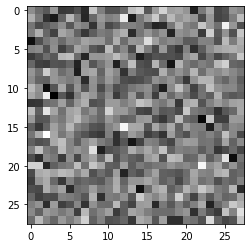

In [100]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')